**Bayesian inference and conformal prediction (prediction intervals) in `nnetsauce` `v0.18.1`**

<span>
<a target="_blank" href="https://colab.research.google.com/github/Techtonique/nnetsauce/blob/master/nnetsauce/demo/thierrymoudiki_20240318_conformal_and_bayesian_regression.ipynb">
  <img style="width: inherit;" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
</span>

Version `0.18.1` of `nnetsauce` (Python version) is available on [PyPI](https://pypi.org/project/nnetsauce/0.18.1/) and for [`conda`](https://anaconda.org/conda-forge/nnetsauce). New developments include __Bayesian inference__ and __conformal prediction__. Bayesian inference is available for `scikit-learn` models that possess a posterior distribution (`BayesianRidge`, `ARDRegressor`, and `GaussianProcessRegressor`). Conformal prediction is available for __every__ regression model that follows the "`fit_predict`" API. Conformal prediction for classification will be available in future versions. 

**Note:** In examples, [QRNN](https://thierrymoudiki.github.io/blog/#QuasiRandomizedNN) = Quasi-Randomized Nnetworks 

# **1 - Installation**

In [ ]:
!pip uninstall nnetsauce --yes

In [ ]:
!pip install nnetsauce --upgrade --no-cache-dir

In [ ]:
!pip install matplotlib==3.1.3

In [96]:
import os 
import nnetsauce as ns 
import matplotlib.pyplot as plt 
import numpy as np 
import warnings
from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge, ARDRegression, RidgeCV
from sklearn.ensemble import ExtraTreesRegressor
from time import time 

# 2 - Useful plotting functions

In [97]:

warnings.filterwarnings('ignore')

split_color = 'green'
split_color2 = 'orange'
local_color = 'gray'

def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title=""):

    fig = plt.figure()

    plt.plot(x, y, 'k.', alpha=.3, markersize=10,
             fillstyle='full', label=u'Test set observations')

    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x, x[::-1]]),
                 np.concatenate([y_u, y_l[::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' Prediction interval')

    if pred is not None:
        plt.plot(x, pred, 'k--', lw=2, alpha=0.9,
                 label=u'Predicted value')

    #plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)

    plt.show()

# 3 - Examples of use

## 3 - 1 Conformalized Quasi-Randomized Nnetworks 

In [98]:
data = fetch_california_housing()
X = data.data
y= data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 123)

# 3 - 1 conformalized QRNN 

## RidgeCV 

Elapsed: 23.05472183227539s
coverage_rate conformalized QRNN RidgeCV: 0.9578488372093024


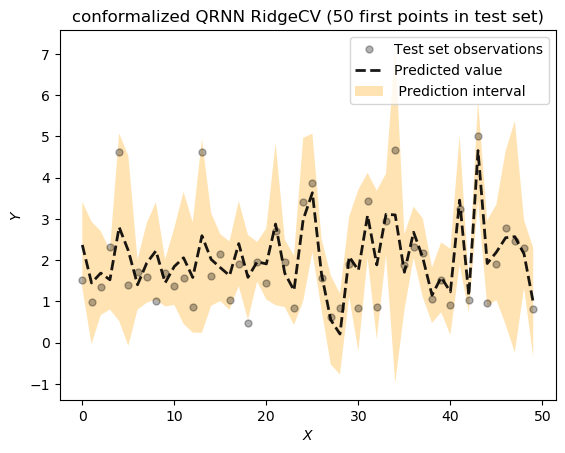

In [99]:
regr1 = ns.CustomRegressor(RidgeCV()) # 5 hidden nodes, ReLU activation function
regr1.fit(X_train, y_train)
start = time()
preds1 = regr1.predict(X_test, method="splitconformal", return_pi=True, level=95)
print(f"Elapsed: {time() - start}s")
print(f"coverage_rate conformalized QRNN RidgeCV: {np.mean((preds1[1]<=y_test)*(preds1[2]>=y_test))}")

max_idx = 50
plot_func(x = range(max_idx),
          y = y_test[0:max_idx],
          y_u = preds1[2][0:max_idx],
          y_l = preds1[1][0:max_idx],
          pred = preds1[0][0:max_idx],
          shade_color=split_color2,
          title = f"conformalized QRNN RidgeCV ({max_idx} first points in test set)")

## Extra Trees

Elapsed: 15.974809169769287s
preds4: (array([2.1156401, 1.11028  , 1.40237  , ..., 0.91221  , 1.94403  ,
       3.1501305]), array([1.2909301, 0.28557  , 0.57766  , ..., 0.0875   , 1.11932  ,
       2.3254205]), array([2.9403501, 1.93499  , 2.22708  , ..., 1.73692  , 2.76874  ,
       3.9748405]))
coverage_rate conformalized QRNN ExtraTreesRegressor: 0.9011627906976745


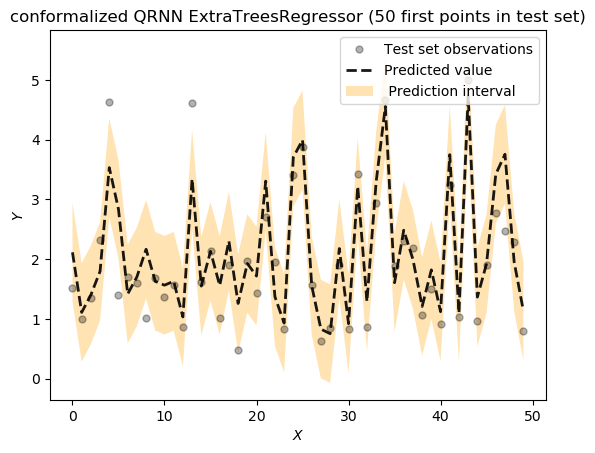

In [100]:
regr4 = ns.CustomRegressor(ExtraTreesRegressor()) # 5 hidden nodes, ReLU activation function
regr4.fit(X_train, y_train)
start = time()
preds4 = regr4.predict(X_test, method="splitconformal", return_pi=True, level=90)
print(f"Elapsed: {time() - start}s")
print(f"preds4: {preds4}")
print(f"coverage_rate conformalized QRNN ExtraTreesRegressor: {np.mean((preds4[1]<=y_test)*(preds4[2]>=y_test))}")

plot_func(x = range(max_idx),
          y = y_test[0:max_idx],
          y_u = preds4[2][0:max_idx],
          y_l = preds4[1][0:max_idx],
          pred = preds4[0][0:max_idx],
          shade_color=split_color2,
          title = f"conformalized QRNN ExtraTreesRegressor ({max_idx} first points in test set)")

## 3 - 2 Bayesian Quasi-Randomized Nnetworks 

## Bayesian Ridge

In [101]:
data = load_diabetes()
X = data.data
y= data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 123)

print(X.shape)
regr = ns.CustomRegressor(BayesianRidge())
start = time()
regr.fit(X_train, y_train)
print(f"Elapsed: {time() - start}s")
preds = regr.predict(X_test, return_std=True)
print(f"coverage_rate Bayesian Ridge: {np.mean((preds[2]<=y_test)*(preds[3]>=y_test))}")


(442, 10)


Elapsed: 0.7585341930389404s
coverage_rate Bayesian Ridge: 0.9775280898876404


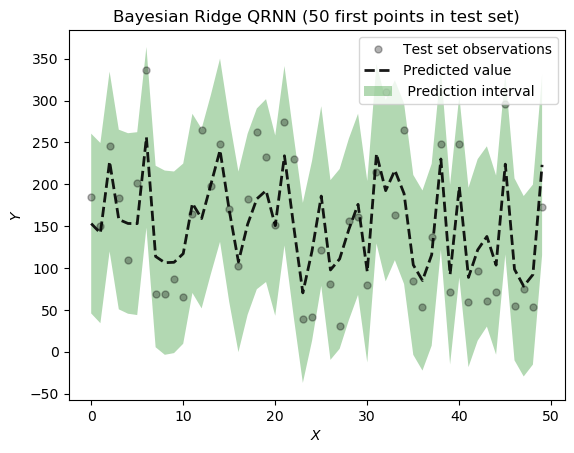

In [102]:
plot_func(x = range(max_idx),
          y = y_test[0:max_idx],
          y_u = preds[3][0:max_idx],
          y_l = preds[2][0:max_idx],
          pred = preds[0][0:max_idx],
          shade_color=split_color,
          title = f"Bayesian Ridge QRNN ({max_idx} first points in test set)")

## ARD Regression

In [103]:
regr2 = ns.CustomRegressor(ARDRegression())
start = time()
regr2.fit(X_train, y_train)
print(f"Elapsed: {time() - start}s")
preds2 = regr2.predict(X_test, return_std=True)
print(f"coverage_rate ARD Regressor: {np.mean((preds2[2]<=y_test)*(preds2[3]>=y_test))}")



Elapsed: 0.8208301067352295s
coverage_rate ARD Regressor: 0.9775280898876404


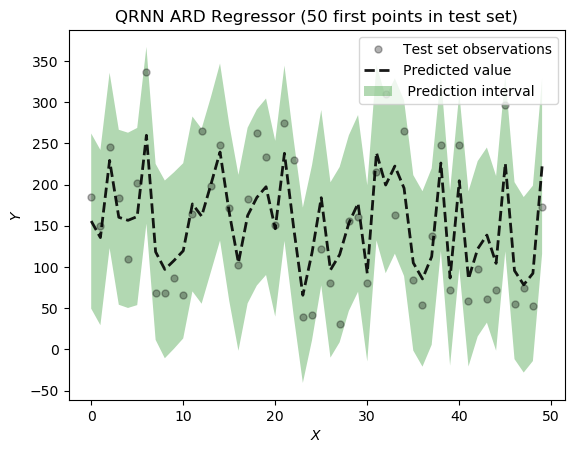

In [104]:
plot_func(x = range(max_idx),
          y = y_test[0:max_idx],
          y_u = preds2[3][0:max_idx],
          y_l = preds2[2][0:max_idx],
          pred = preds2[0][0:max_idx],
          shade_color=split_color,
          title = f"QRNN ARD Regressor ({max_idx} first points in test set)")